# Pokemon Classifier (Gen 1)

Construction d'un CNN pour identifier un pokemon de 1ère génération (151 classes à prédire)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models


In [18]:
## Config
from pathlib import Path

# Chemins
data_path = Path('./PokemonData')
pokemon_dirs = sorted([d for d in data_path.iterdir() if d.is_dir()])

# Compter les images par répertoire
image_counts = {}
image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}

# Créer les listes image_paths et labels
image_paths = []
labels = []

for pokemon_dir in pokemon_dirs:
    pokemon_name = pokemon_dir.name
    images = [f for f in pokemon_dir.iterdir()
            if f.is_file() and f.suffix.lower() in image_extensions]

    for img_path in images:
        image_paths.append(str(img_path))
        labels.append(pokemon_name)

# Convertir en array numpy
image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"Total images: {len(image_paths)}")
print(f"Total labels: {len(labels)}")
print(f"Exemple - 1ère image: {image_paths[0]}")
print(f"Exemple - 1er label: {labels[0]}")


Total images: 32472
Total labels: 32472
Exemple - 1ère image: PokemonData/Abo/000032.png
Exemple - 1er label: Abo


## Analyse du dataset

1 répertoire par classe contenant plusieurs images du pokemon à identifier

In [19]:


for pokemon_dir in pokemon_dirs:
    images = [f for f in pokemon_dir.iterdir() 
              if f.is_file() and f.suffix.lower() in image_extensions]
    image_counts[pokemon_dir.name] = len(images)

# Créer une série pandas pour les statistiques
counts = pd.Series(image_counts)

# Afficher les statistiques
print("="*60)
print("ANALYSE EXPLORATOIRE - DATASET POKEMON")
print("="*60)
print(f"\n📊 Nombre de classes (répertoires) : {len(pokemon_dirs)}")
print(f"📸 Nombre total d'images : {counts.sum()}")
print(f"\n📈 STATISTIQUES DU NOMBRE D'IMAGES PAR CLASSE:")
print(f"  • Minimum  : {counts.min()} images")
print(f"  • Maximum  : {counts.max()} images")
print(f"  • Moyenne  : {counts.mean():.2f} images")
print(f"  • Médiane  : {counts.median():.2f} images")

# Classes avec moins et plus d'images
print(f"\n🔽 Classes avec le MOINS d'images:")
print(counts.nsmallest(5))
print(f"\n🔼 Classes avec le PLUS d'images:")
print(counts.nlargest(5))



ANALYSE EXPLORATOIRE - DATASET POKEMON

📊 Nombre de classes (répertoires) : 151
📸 Nombre total d'images : 32472

📈 STATISTIQUES DU NOMBRE D'IMAGES PAR CLASSE:
  • Minimum  : 117 images
  • Maximum  : 486 images
  • Moyenne  : 215.05 images
  • Médiane  : 207.00 images

🔽 Classes avec le MOINS d'images:
Nidoran♀    117
Persian     125
Onix        128
Kabuto      133
Abra        137
dtype: int64

🔼 Classes avec le PLUS d'images:
Pikachu      486
Salamèche    451
Mewtwo       439
Psykokwak    428
Carapuce     423
dtype: int64


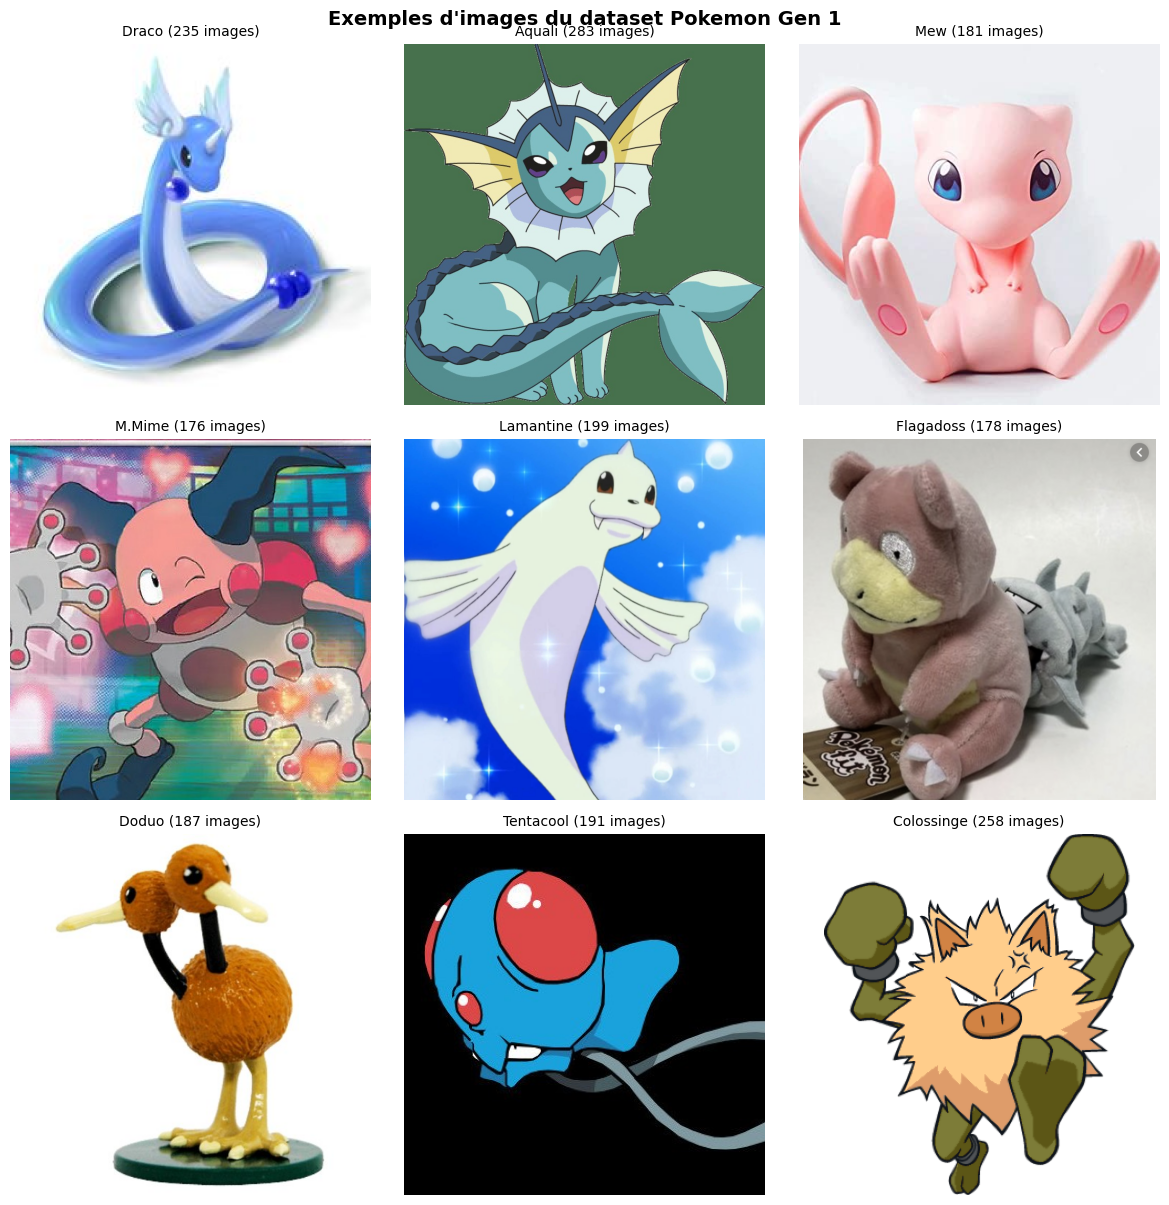

In [20]:
import random
from PIL import Image

# Sélectionner 9 images aléatoires de 9 classes différentes
random.seed(42)
sample_dirs = random.sample(pokemon_dirs, 9)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for idx, pokemon_dir in enumerate(sample_dirs):
    # Trouver une image dans ce répertoire
    images = [f for f in pokemon_dir.iterdir() 
              if f.is_file() and f.suffix.lower() in image_extensions]
    
    if images:
        img_path = images[0]
        img = Image.open(img_path)
        
        axes[idx].imshow(img)
        axes[idx].set_title(f"{pokemon_dir.name} ({len(images)} images)", fontsize=10)
        axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Exemples d\'images du dataset Pokemon Gen 1', fontsize=14, fontweight='bold', y=1.00)
plt.show()

In [21]:
# Split 1: 80% train+val vs 20% temp (qui sera val+test)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Split 2: Diviser les 20% en 50/50 (= 10% val, 10% test)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels,
    test_size=0.5,
    stratify=test_labels,
    random_state=42
)

# Renommer pour clarté
train_paths = train_val_paths
train_labels = train_val_labels

print(f"Train: {len(train_paths)} images ({len(train_paths)/len(image_paths)*100:.1f}%)")
print(f"Val:   {len(val_paths)} images ({len(val_paths)/len(image_paths)*100:.1f}%)")
print(f"Test:  {len(test_paths)} images ({len(test_paths)/len(image_paths)*100:.1f}%)")

# Vérifier que chaque classe est représentée
print(f"\nClasses en train: {len(np.unique(train_labels))}")
print(f"Classes en val: {len(np.unique(val_labels))}")
print(f"Classes en test: {len(np.unique(test_labels))}")

Train: 25977 images (80.0%)
Val:   3247 images (10.0%)
Test:  3248 images (10.0%)

Classes en train: 151
Classes en val: 151
Classes en test: 151


In [22]:
# Calculer le nombre de classes dynamiquement
num_classes = len(np.unique(labels))
print(f"🎯 Nombre de classes détecté: {num_classes}")

image_shape = (256, 256, 3)

# ✅ Modèle SIMPLIFIÉ : 3 blocs Conv + 1 Dense (~2M params)
# Plus efficace pour 26k images que le modèle à 6M params
model = models.Sequential([
    # Input layer
    layers.Input(image_shape),

    # Block 1: 32 filtres
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2: 64 filtres
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3: 128 filtres
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Global Average Pooling (plus efficace que Flatten)
    layers.GlobalAveragePooling2D(),

    # Une seule couche Dense
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Output
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

# Compter les paramètres
total_params = model.count_params()
print("\n" + "="*60)
print("ARCHITECTURE SIMPLIFIÉE")
print("="*60)
print(f"✅ Total paramètres: {total_params:,}")
print(f"   (vs ~6M avant = {6_000_000/total_params:.1f}x plus léger)")
print(f"\n🏗️  Architecture:")
print(f"   • 3 blocs Conv (32→64→128) au lieu de 4")
print(f"   • GlobalAveragePooling au lieu de Flatten")
print(f"   • 1 Dense(256) au lieu de Dense(512)→Dense(256)")
print(f"\n⚡ Avantages:")
print(f"   • Training ~2-3x plus rapide")
print(f"   • Moins d'overfitting")
print(f"   • Meilleure généralisation")
print("="*60)

🎯 Nombre de classes détecté: 151


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 361,655 (1.38 MB)

 Trainable params: 360,247 (1.37 MB)

 Non-trainable params: 1,408 (5.50 KB)


ARCHITECTURE SIMPLIFIÉE
✅ Total paramètres: 361,655
   (vs ~6M avant = 16.6x plus léger)

🏗️  Architecture:
   • 3 blocs Conv (32→64→128) au lieu de 4
   • GlobalAveragePooling au lieu de Flatten
   • 1 Dense(256) au lieu de Dense(512)→Dense(256)

⚡ Avantages:
   • Training ~2-3x plus rapide
   • Moins d'overfitting
   • Meilleure généralisation


In [23]:
## Learning Rate Scheduling Avancé

# Warmup + Cosine Decay
def warmup_cosine_decay(epoch, total_epochs=20, warmup_epochs=5, 
                        initial_lr=0.001, min_lr=1e-6):
    """
    Learning rate avec warmup puis cosine decay
    - Warmup: augmente linéairement pendant warmup_epochs
    - Cosine decay: décroissance en cosinus jusqu'à min_lr
    """
    if epoch < warmup_epochs:
        # Phase de warmup: augmentation linéaire
        lr = initial_lr * (epoch / warmup_epochs)
    else:
        # Phase de decay: cosine annealing
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        lr = min_lr + (initial_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * progress))
    
    return lr

# Créer le callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(warmup_cosine_decay, verbose=1)

# Compilation du modèle
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Modèle compilé avec Learning Rate Scheduling:")
print("  • Warmup: 0 → 0.001 pendant 5 epochs")
print("  • Cosine Decay: 0.001 → 1e-6 ensuite")
print("  • Adaptation dynamique du learning rate")

✅ Modèle compilé avec Learning Rate Scheduling:
  • Warmup: 0 → 0.001 pendant 5 epochs
  • Cosine Decay: 0.001 → 1e-6 ensuite
  • Adaptation dynamique du learning rate


In [24]:
## Callback pour visualisation en temps réel

from IPython.display import clear_output

class LivePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['accuracy'])
        self.val_acc.append(logs['val_accuracy'])
        
        # Clear output et redessiner
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss
        ax1.plot(self.epochs, self.train_loss, 'b-', label='Train Loss', linewidth=2, marker='o')
        ax1.plot(self.epochs, self.val_loss, 'r-', label='Val Loss', linewidth=2, marker='o')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss en temps réel', fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Accuracy
        ax2.plot(self.epochs, self.train_acc, 'b-', label='Train Acc', linewidth=2, marker='o')
        ax2.plot(self.epochs, self.val_acc, 'r-', label='Val Acc', linewidth=2, marker='o')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy en temps réel', fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Statistiques
        print("="*80)
        print(f"EPOCH {epoch + 1}/{self.params['epochs']}")
        print("="*80)
        print(f"📊 Loss      → Train: {logs['loss']:.4f} | Val: {logs['val_loss']:.4f} | Écart: {abs(logs['loss'] - logs['val_loss']):.4f}")
        print(f"🎯 Accuracy  → Train: {logs['accuracy']:.4f} ({logs['accuracy']*100:.2f}%) | Val: {logs['val_accuracy']:.4f} ({logs['val_accuracy']*100:.2f}%) | Écart: {abs(logs['accuracy'] - logs['val_accuracy'])*100:.2f}%")
        
        # Diagnostic
        gap = logs['accuracy'] - logs['val_accuracy']
        if gap > 0.1:
            print("⚠️  OVERFITTING détecté!")
        elif gap > 0.05:
            print("⚡ Léger overfitting")
        else:
            print("✅ Bon équilibre")
        
        # Meilleure val accuracy jusqu'ici
        best_val_acc = max(self.val_acc)
        best_epoch = self.val_acc.index(best_val_acc) + 1
        print(f"\n🏆 Meilleure Val Acc: {best_val_acc:.4f} ({best_val_acc*100:.2f}%) à l'epoch {best_epoch}")
        print("="*80)

# Autres callbacks utiles
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

print("✅ Callbacks créés:")
print("  • LivePlotCallback: graphiques en temps réel")
print("  • EarlyStopping: arrêt si pas d'amélioration (patience=5)")
print("  • ReduceLROnPlateau: réduit learning rate (patience=3)")

✅ Callbacks créés:
  • LivePlotCallback: graphiques en temps réel
  • EarlyStopping: arrêt si pas d'amélioration (patience=5)
  • ReduceLROnPlateau: réduit learning rate (patience=3)


In [25]:
# Mapping labels -> indices -> one-hot
unique_labels = sorted(np.unique(train_labels))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
num_classes = len(unique_labels)

train_labels_idx = np.array([label_to_idx[label] for label in train_labels])
val_labels_idx = np.array([label_to_idx[label] for label in val_labels])
test_labels_idx = np.array([label_to_idx[label] for label in test_labels])

# One-hot encoding
train_labels_onehot = tf.keras.utils.to_categorical(train_labels_idx, num_classes)
val_labels_onehot = tf.keras.utils.to_categorical(val_labels_idx, num_classes)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels_idx, num_classes)

print(f"📊 Nombre de classes: {num_classes}")

# Fonction de chargement d'image
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (256, 256))
    return img, label

# ✅ Data Augmentation MODÉRÉE pour CNN from scratch
# (moins agressive que transfer learning car le modèle apprend de zéro)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),          # ±18° seulement (était 0.3 = ±108°)
    layers.RandomZoom(0.1),               # ±10% zoom (était 0.2)
    layers.RandomContrast(0.15),          # ±15% contraste (était 0.2)
    layers.RandomBrightness(0.15),        # ±15% luminosité (était 0.2)
    # Translation retirée : déstabilise trop un CNN from scratch
], name="data_augmentation")

def augment_and_normalize(img, label):
    """Applique augmentation puis normalisation"""
    img = data_augmentation(img, training=True)
    img = img / 255.0
    return img, label

def normalize_only(img, label):
    """Applique seulement la normalisation (pour val/test)"""
    img = img / 255.0
    return img, label

# Créer les datasets
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

# Train dataset (avec augmentation modérée)
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_onehot))
train_dataset = train_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(augment_and_normalize, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)

# Val dataset (sans augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels_onehot))
val_dataset = val_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(normalize_only, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(AUTOTUNE)

# Test dataset (sans augmentation)
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels_onehot))
test_dataset = test_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(normalize_only, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

print("✅ Datasets créés avec AUGMENTATION MODÉRÉE (CNN from scratch) :")
print("\n📝 Transformations appliquées (Train) :")
print("  • RandomFlip horizontal")
print("  • RandomRotation ±18° (modéré)")
print("  • RandomZoom ±10% (modéré)")
print("  • RandomContrast ±15%")
print("  • RandomBrightness ±15%")
print("\n⚠️  Augmentation moins agressive que Transfer Learning")
print("    (CNN from scratch doit apprendre les features de base)")
print(f"\nTrain: {len(train_paths)} images")
print(f"Val: {len(val_paths)} images")
print(f"Test: {len(test_paths)} images")

📊 Nombre de classes: 151
✅ Datasets créés avec AUGMENTATION MODÉRÉE (CNN from scratch) :

📝 Transformations appliquées (Train) :
  • RandomFlip horizontal
  • RandomRotation ±18° (modéré)
  • RandomZoom ±10% (modéré)
  • RandomContrast ±15%
  • RandomBrightness ±15%

⚠️  Augmentation moins agressive que Transfer Learning
    (CNN from scratch doit apprendre les features de base)

Train: 25977 images
Val: 3247 images
Test: 3248 images


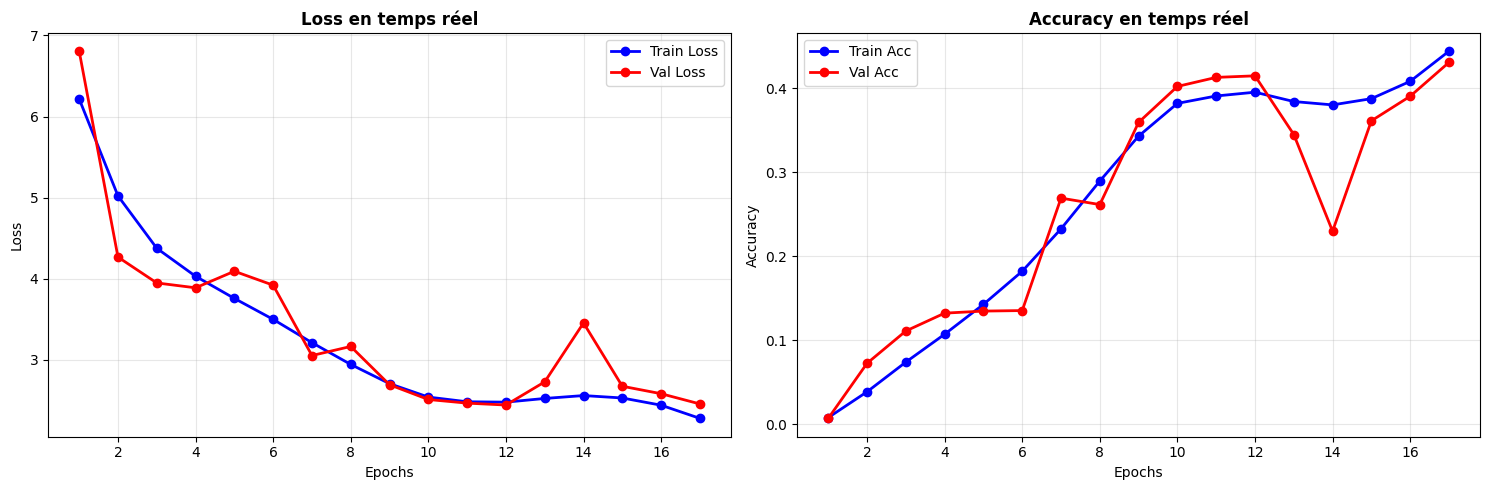

EPOCH 17/50
📊 Loss      → Train: 2.2788 | Val: 2.4566 | Écart: 0.1778
🎯 Accuracy  → Train: 0.4442 (44.42%) | Val: 0.4309 (43.09%) | Écart: 1.33%
✅ Bon équilibre

🏆 Meilleure Val Acc: 0.4309 (43.09%) à l'epoch 17
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.

✅ Entraînement terminé avec AMÉLIORATIONS:
  • Augmentation avancée (rotation, saturation, zoom)
  • Learning rate scheduling (warmup + cosine decay)


In [26]:
## Entraînement du modèle avec callbacks OPTIMISÉS

# Créer le callback de visualisation
live_plot = LivePlotCallback()

# Lancer l'entraînement avec tous les callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[
        live_plot,           # Visualisation en temps réel
        early_stopping,      # Arrêt si pas d'amélioration
        lr_scheduler,        # Learning rate dynamique (NOUVEAU)
        reduce_lr            # Backup si LR stagne
    ],
    verbose=0  # Désactivé car on affiche avec LivePlotCallback
)

print("\n✅ Entraînement terminé avec AMÉLIORATIONS:")
print("  • Augmentation avancée (rotation, saturation, zoom)")
print("  • Learning rate scheduling (warmup + cosine decay)")

## Analyse des résultats d'entraînement

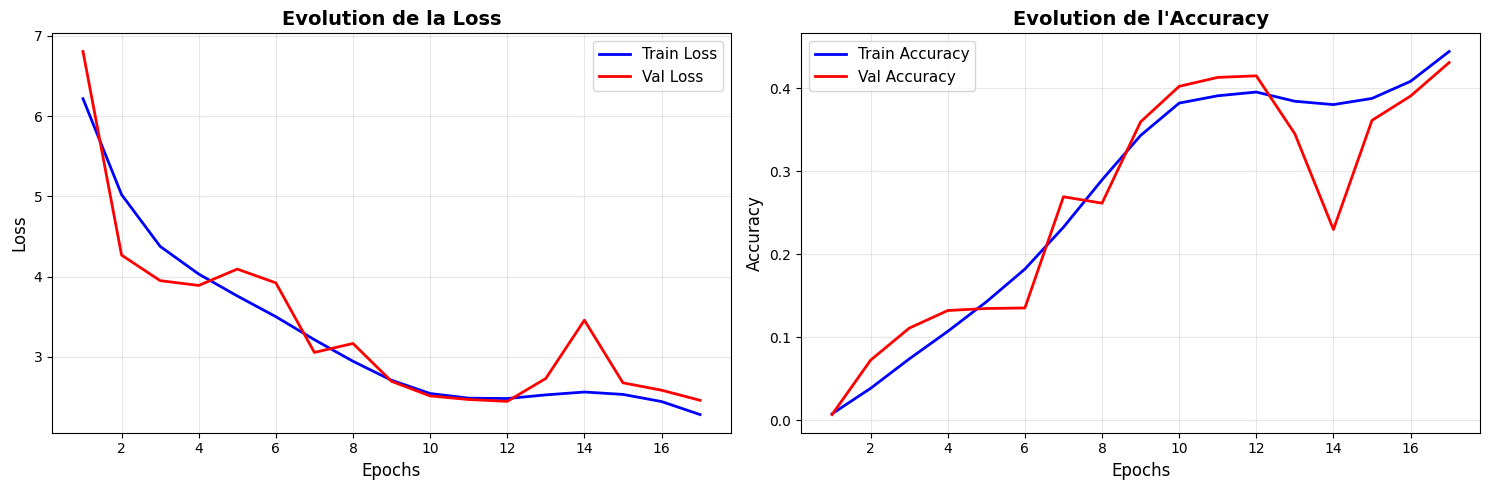

STATISTIQUES FINALES

📊 Loss finale:
  • Train: 2.2788
  • Val:   2.4566
  • Écart: 0.1778

🎯 Accuracy finale:
  • Train: 0.4442 (44.42%)
  • Val:   0.4309 (43.09%)
  • Écart: 0.0133 (1.33%)

📈 Meilleure Val Accuracy:
  • Epoch 17: 0.4309 (43.09%)

📉 Meilleure Val Loss:
  • Epoch 12: 2.4433

🔍 DIAGNOSTIC:
  ✅ Bon équilibre train-val (écart < 5%)
  📊 Accuracy modérée, amélioration possible


In [27]:
# Extraire les métriques
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(train_loss) + 1)

# Créer les graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graphique Loss
ax1.plot(epochs_range, train_loss, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, val_loss, 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Evolution de la Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Graphique Accuracy
ax2.plot(epochs_range, train_acc, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs_range, val_acc, 'r-', label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Evolution de l\'Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques finales
print("="*60)
print("STATISTIQUES FINALES")
print("="*60)
print(f"\n📊 Loss finale:")
print(f"  • Train: {train_loss[-1]:.4f}")
print(f"  • Val:   {val_loss[-1]:.4f}")
print(f"  • Écart: {abs(train_loss[-1] - val_loss[-1]):.4f}")

print(f"\n🎯 Accuracy finale:")
print(f"  • Train: {train_acc[-1]:.4f} ({train_acc[-1]*100:.2f}%)")
print(f"  • Val:   {val_acc[-1]:.4f} ({val_acc[-1]*100:.2f}%)")
print(f"  • Écart: {abs(train_acc[-1] - val_acc[-1]):.4f} ({abs(train_acc[-1] - val_acc[-1])*100:.2f}%)")

print(f"\n📈 Meilleure Val Accuracy:")
best_val_acc_epoch = np.argmax(val_acc) + 1
print(f"  • Epoch {best_val_acc_epoch}: {max(val_acc):.4f} ({max(val_acc)*100:.2f}%)")

print(f"\n📉 Meilleure Val Loss:")
best_val_loss_epoch = np.argmin(val_loss) + 1
print(f"  • Epoch {best_val_loss_epoch}: {min(val_loss):.4f}")

# Diagnostic
print(f"\n🔍 DIAGNOSTIC:")
gap = train_acc[-1] - val_acc[-1]
if gap > 0.1:
    print("  ⚠️  OVERFITTING détecté (écart train-val > 10%)")
    print("  → Solutions: plus de régularisation, dropout, early stopping")
elif gap > 0.05:
    print("  ⚡ Léger overfitting (écart train-val entre 5-10%)")
    print("  → Acceptable, mais pourrait être amélioré")
else:
    print("  ✅ Bon équilibre train-val (écart < 5%)")

if val_acc[-1] < 0.3:
    print("  ⚠️  Accuracy très faible, modèle sous-performant")
elif val_acc[-1] < 0.5:
    print("  📊 Accuracy modérée, amélioration possible")
elif val_acc[-1] < 0.7:
    print("  📈 Bonne accuracy pour 151 classes")
else:
    print("  🏆 Excellente accuracy!")

print("="*60)

## Sauvegarde du modèle

In [28]:
# Sauvegarder le modèle au format .keras (moderne)
model_path = 'pokemon_classifier.keras'
model.save(model_path)
print(f"✅ Modèle sauvegardé : {model_path}")

# Pour le recharger plus tard :
# model = tf.keras.models.load_model('pokemon_classifier.keras')

✅ Modèle sauvegardé : pokemon_classifier.keras


## Évaluation sur le Test Set

In [29]:
# Évaluer sur le test set
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

print("\n" + "="*60)
print("RÉSULTATS SUR LE TEST SET")
print("="*60)
print(f"🎯 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"📊 Test Loss: {test_loss:.4f}")
print("="*60)

# Comparer avec validation
print(f"\n📊 Comparaison Val vs Test:")
print(f"  Val Accuracy:  {val_acc[-1]:.4f} ({val_acc[-1]*100:.2f}%)")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Écart: {abs(val_acc[-1] - test_accuracy)*100:.2f}%")

  1/102 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - accuracy: 0.4062 - loss: 2.5393

2025-11-30 19:15:40.587467: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:40.747939: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  4/102 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.4395 - loss: 2.3922

2025-11-30 19:15:40.999441: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  6/102 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.4522 - loss: 2.3708

2025-11-30 19:15:41.223877: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: bKGD: invalid
2025-11-30 19:15:41.241305: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:41.349320: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:41.354113: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  8/102 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.4549 - loss: 2.3696

2025-11-30 19:15:41.485501: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 11/102 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.4514 - loss: 2.3864

2025-11-30 19:15:41.877512: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
2025-11-30 19:15:41.989018: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 14/102 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.4506 - loss: 2.3991

2025-11-30 19:15:42.253195: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:42.374800: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 19/102 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.4500 - loss: 2.4131

2025-11-30 19:15:42.873865: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:42.997870: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 21/102 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.4498 - loss: 2.4163

2025-11-30 19:15:43.124613: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 23/102 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.4487 - loss: 2.4204 

2025-11-30 19:15:43.384555: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:43.393364: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:43.524278: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 31/102 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.4446 - loss: 2.4228

2025-11-30 19:15:44.402000: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:44.528336: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 35/102 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.4442 - loss: 2.4204

2025-11-30 19:15:44.913492: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:45.024635: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 38/102 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.4443 - loss: 2.4189

2025-11-30 19:15:45.274738: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:45.274901: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 41/102 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.4442 - loss: 2.4179

2025-11-30 19:15:45.664474: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:45.781526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 45/102 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.4440 - loss: 2.4162

2025-11-30 19:15:46.165332: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 50/102 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.4440 - loss: 2.4145

2025-11-30 19:15:46.791486: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:46.915440: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 55/102 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.4444 - loss: 2.4122

2025-11-30 19:15:47.417070: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:47.548361: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 59/102 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.4450 - loss: 2.4094

2025-11-30 19:15:47.924589: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 61/102 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.4454 - loss: 2.4077

2025-11-30 19:15:48.179670: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:48.320670: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 67/102 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.4462 - loss: 2.4033

2025-11-30 19:15:48.932220: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:49.048667: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:49.062347: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 69/102 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.4464 - loss: 2.4019

2025-11-30 19:15:49.178604: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:49.297721: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: out-of-date sRGB profile with no signature


 71/102 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.4466 - loss: 2.4006

2025-11-30 19:15:49.424219: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:49.426566: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 74/102 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.4469 - loss: 2.3989

2025-11-30 19:15:49.800143: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 77/102 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.4471 - loss: 2.3975

2025-11-30 19:15:50.194867: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 82/102 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.4472 - loss: 2.3960

2025-11-30 19:15:50.698819: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:50.698830: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2025-11-30 19:15:50.772251: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 85/102 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.4472 - loss: 2.3950

2025-11-30 19:15:50.929372: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:51.089929: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:51.099397: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 88/102 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4472 - loss: 2.3940

2025-11-30 19:15:51.162987: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:51.248264: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:51.256169: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:51.330784: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 94/102 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4472 - loss: 2.3924

2025-11-30 19:15:51.630811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:51.794147: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 97/102 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4471 - loss: 2.3915

2025-11-30 19:15:51.879662: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.4489 - loss: 2.3544

RÉSULTATS SUR LE TEST SET
🎯 Test Accuracy: 0.4489 (44.89%)
📊 Test Loss: 2.3544

📊 Comparaison Val vs Test:
  Val Accuracy:  0.4309 (43.09%)
  Test Accuracy: 0.4489 (44.89%)
  Écart: 1.80%


## Matrice de confusion et Classification Report

2025-11-30 19:15:52.487933: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  2/102 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step

2025-11-30 19:15:52.811837: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  4/102 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step

2025-11-30 19:15:53.061161: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  6/102 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step

2025-11-30 19:15:53.309525: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: bKGD: invalid
2025-11-30 19:15:53.332345: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:53.436103: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:53.441503: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  8/102 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step

2025-11-30 19:15:53.570402: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 11/102 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step

2025-11-30 19:15:53.952979: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 1000000h: invalid rendering intent
2025-11-30 19:15:54.062388: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 14/102 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step

2025-11-30 19:15:54.324538: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:54.449706: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 19/102 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step

2025-11-30 19:15:54.935193: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:55.062441: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 21/102 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step

2025-11-30 19:15:55.185799: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 23/102 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step

2025-11-30 19:15:55.440659: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:55.450886: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:55.581299: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 31/102 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step

2025-11-30 19:15:56.436343: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:56.542633: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 35/102 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step

2025-11-30 19:15:56.908167: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:57.019868: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 38/102 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step

2025-11-30 19:15:57.270246: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:57.270283: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 41/102 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step

2025-11-30 19:15:57.655236: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:57.768866: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 45/102 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step

2025-11-30 19:15:58.144939: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 50/102 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step

2025-11-30 19:15:58.769207: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:58.895539: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 55/102 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step

2025-11-30 19:15:59.394918: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:15:59.529138: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 59/102 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step

2025-11-30 19:15:59.885841: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 61/102 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step

2025-11-30 19:16:00.141967: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:16:00.289091: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 67/102 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step

2025-11-30 19:16:00.893869: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:16:01.010695: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:16:01.023864: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 69/102 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step

2025-11-30 19:16:01.124817: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:16:01.244387: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: out-of-date sRGB profile with no signature


 71/102 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step

2025-11-30 19:16:01.368948: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:16:01.370429: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 74/102 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step

2025-11-30 19:16:01.711616: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 77/102 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step

2025-11-30 19:16:02.096471: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 82/102 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step

2025-11-30 19:16:02.585870: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:16:02.585919: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: cHRM chunk does not match sRGB
2025-11-30 19:16:02.666859: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 85/102 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step

2025-11-30 19:16:02.820040: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:16:02.982800: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:16:02.993816: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 88/102 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step

2025-11-30 19:16:03.052553: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:16:03.121578: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:16:03.129195: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:16:03.213906: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 94/102 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

2025-11-30 19:16:03.501539: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-11-30 19:16:03.646380: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 97/102 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

2025-11-30 19:16:03.731319: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step


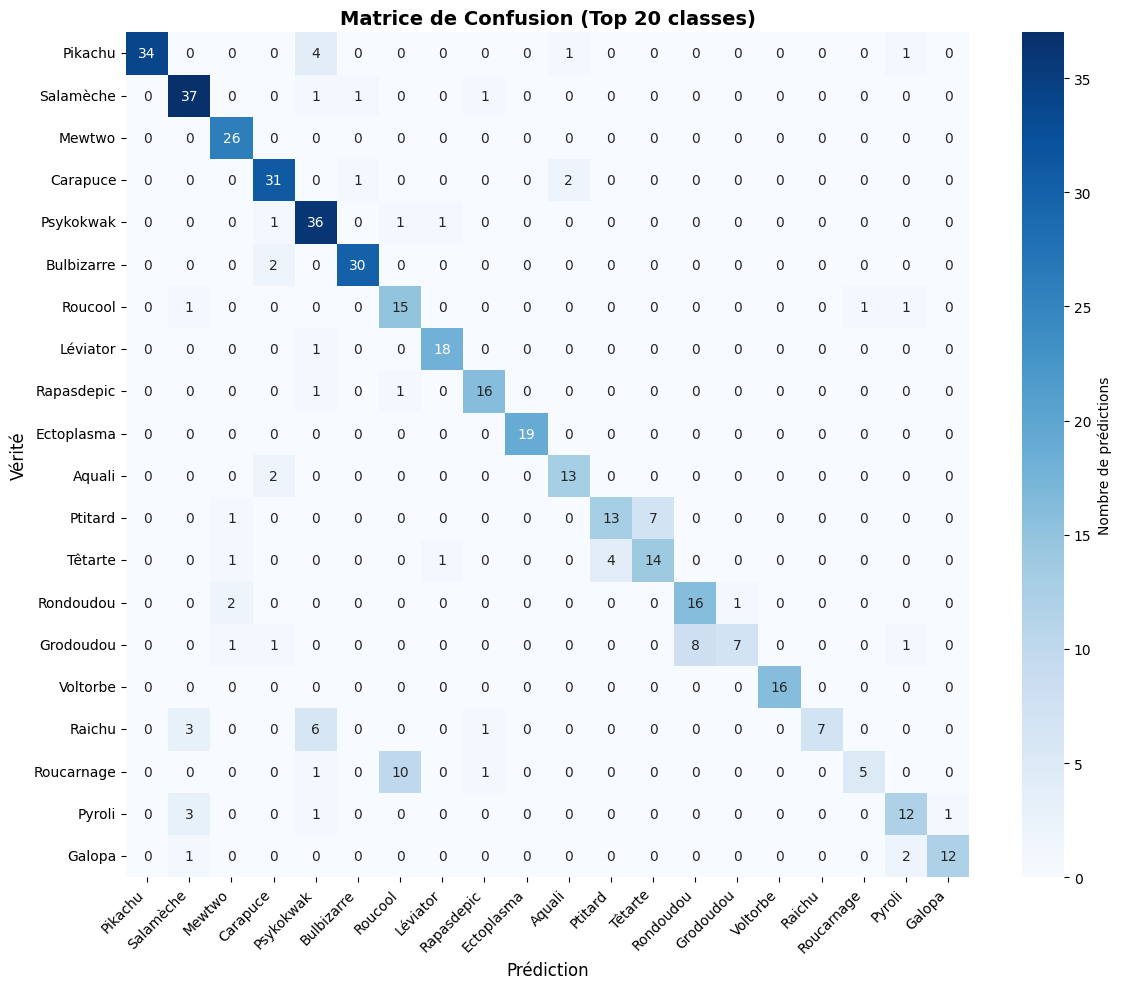


CLASSIFICATION REPORT (Toutes les classes)

📊 Métriques globales:
  Accuracy:  0.4489 (44.89%)
  Precision: 0.4647
  Recall:    0.4248
  F1-Score:  0.4196


In [30]:
# Prédictions sur le test set
y_pred_proba = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(test_labels_onehot, axis=1)

# Matrice de confusion (simplifiée : top 20 classes les plus fréquentes)
from sklearn.metrics import confusion_matrix, classification_report

# Trouver les 20 classes les plus fréquentes dans le test set
top_20_classes = pd.Series(y_true).value_counts().head(20).index.tolist()
top_20_names = [list(label_to_idx.keys())[i] for i in top_20_classes]

# Filter predictions for top 20 classes
mask = np.isin(y_true, top_20_classes)
y_true_top20 = y_true[mask]
y_pred_top20 = y_pred[mask]

# Matrice de confusion
cm = confusion_matrix(y_true_top20, y_pred_top20, labels=top_20_classes)

# Visualiser
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=top_20_names, yticklabels=top_20_names,
            cbar_kws={'label': 'Nombre de prédictions'})
plt.title('Matrice de Confusion (Top 20 classes)', fontsize=14, fontweight='bold')
plt.xlabel('Prédiction', fontsize=12)
plt.ylabel('Vérité', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report (global)
print("\n" + "="*80)
print("CLASSIFICATION REPORT (Toutes les classes)")
print("="*80)
report = classification_report(y_true, y_pred, 
                               target_names=list(label_to_idx.keys()),
                               output_dict=True, zero_division=0)

# Afficher statistiques globales
print(f"\n📊 Métriques globales:")
print(f"  Accuracy:  {report['accuracy']:.4f} ({report['accuracy']*100:.2f}%)")
print(f"  Precision: {report['macro avg']['precision']:.4f}")
print(f"  Recall:    {report['macro avg']['recall']:.4f}")
print(f"  F1-Score:  {report['macro avg']['f1-score']:.4f}")
print("="*80)

## Visualisation des prédictions

✅ Modèle chargé depuis pokemon_classifier.keras


/var/folders/4c/jc90j_x9027gmqr7h5m7yhxh0000gn/T/ipykernel_90684/4122436696.py:50: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4c/jc90j_x9027gmqr7h5m7yhxh0000gn/T/ipykernel_90684/4122436696.py:50: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/erwan/Dev/Alyra/ProjetFinal/DL-PokemonClassification/tf-venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/erwan/Dev/Alyra/ProjetFinal/DL-PokemonClassification/tf-venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


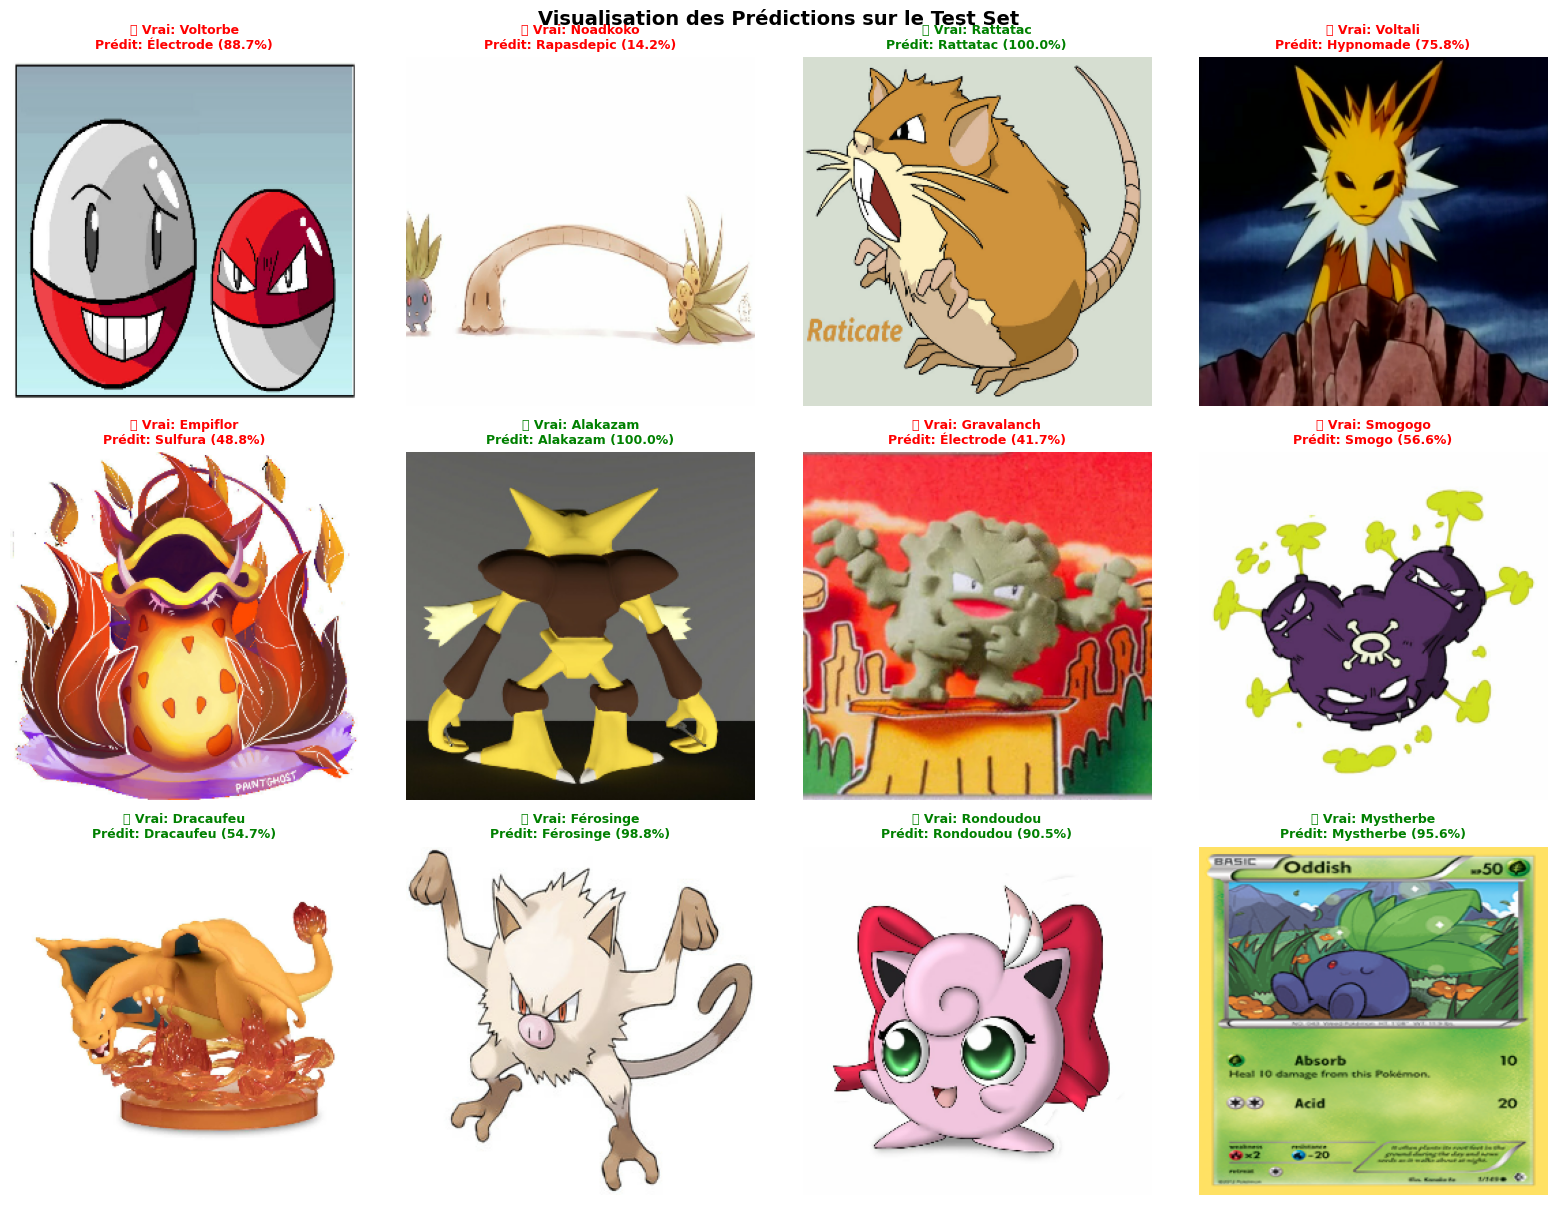


📊 Résultats sur cet échantillon:
  ✅ Correct: 6/12 (50.0%)
  ❌ Incorrect: 6/12 (50.0%)


In [31]:
# Charger le modèle sauvegardé
loaded_model = tf.keras.models.load_model('pokemon_classifier77.keras')
print("✅ Modèle chargé depuis pokemon_classifier.keras")

# Sélectionner 12 images aléatoires du test set
np.random.seed(3)
random_indices = np.random.choice(len(test_paths), 12, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, test_idx in enumerate(random_indices):
    # Charger l'image
    img_path = test_paths[test_idx]
    img = tf.io.read_file(img_path)
    # CORRIGÉ: decode_image au lieu de decode_jpeg
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img_resized = tf.image.resize(img, (256, 256))
    img_normalized = img_resized / 255.0
    
    # Prédiction
    img_batch = tf.expand_dims(img_normalized, 0)
    prediction = loaded_model.predict(img_batch, verbose=0)
    predicted_class_idx = np.argmax(prediction[0])
    predicted_class = list(label_to_idx.keys())[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx]
    
    # Vraie classe
    true_class = test_labels[test_idx]
    
    # Afficher
    axes[idx].imshow(img_resized.numpy().astype('uint8'))
    
    # Couleur selon résultat
    if predicted_class == true_class:
        color = 'green'
        symbol = '✅'
    else:
        color = 'red'
        symbol = '❌'
    
    axes[idx].set_title(
        f"{symbol} Vrai: {true_class}\nPrédit: {predicted_class} ({confidence*100:.1f}%)",
        fontsize=9,
        color=color,
        fontweight='bold'
    )
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Visualisation des Prédictions sur le Test Set', 
             fontsize=14, fontweight='bold', y=1.00)
plt.show()

# Statistiques (version simplifiée et corrigée)
correct = 0
for i in random_indices:
    img = tf.io.read_file(test_paths[i])
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (256, 256)) / 255.0
    pred = loaded_model.predict(tf.expand_dims(img, 0), verbose=0)
    pred_class = list(label_to_idx.keys())[np.argmax(pred[0])]
    if test_labels[i] == pred_class:
        correct += 1

print(f"\n📊 Résultats sur cet échantillon:")
print(f"  ✅ Correct: {correct}/{len(random_indices)} ({correct/len(random_indices)*100:.1f}%)")
print(f"  ❌ Incorrect: {len(random_indices)-correct}/{len(random_indices)} ({(len(random_indices)-correct)/len(random_indices)*100:.1f}%)")

## Prédiction sur images externes

📂 6 images trouvées dans Test_Img_Externes



/var/folders/4c/jc90j_x9027gmqr7h5m7yhxh0000gn/T/ipykernel_90684/2710142057.py:68: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4c/jc90j_x9027gmqr7h5m7yhxh0000gn/T/ipykernel_90684/2710142057.py:68: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4c/jc90j_x9027gmqr7h5m7yhxh0000gn/T/ipykernel_90684/2710142057.py:68: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/erwan/Dev/Alyra/ProjetFinal/DL-PokemonClassification/tf-venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/erwan/Dev/Alyra/ProjetFinal/DL-PokemonClassification/tf-venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) 

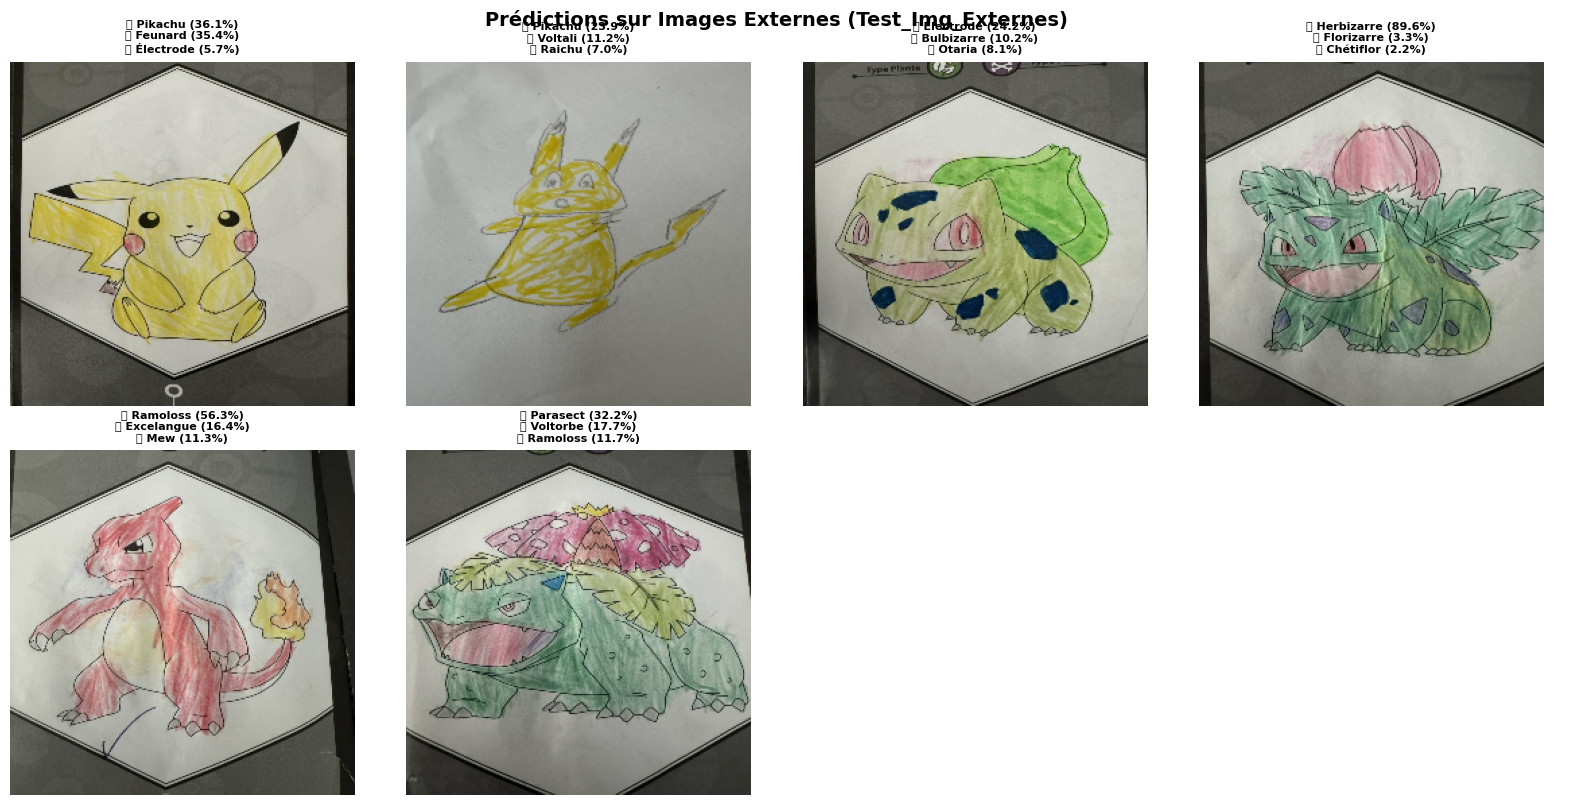


✅ Prédictions effectuées sur 6 images


In [32]:
# Répertoire des images externes à tester
external_images_dir = Path('./Test_Img_Externes')

# Vérifier si le répertoire existe
if not external_images_dir.exists():
    print(f"⚠️  Le répertoire {external_images_dir} n'existe pas")
    print("   Créez-le et ajoutez des images Pokemon pour tester le modèle")
else:
    # Charger toutes les images du répertoire
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}
    external_images = [f for f in external_images_dir.iterdir() 
                      if f.is_file() and f.suffix.lower() in image_extensions]
    
    if len(external_images) == 0:
        print(f"⚠️  Aucune image trouvée dans {external_images_dir}")
    else:
        print(f"📂 {len(external_images)} images trouvées dans {external_images_dir}\n")
        
        # Déterminer la grille (max 12 images)
        num_images = min(len(external_images), 12)
        cols = 4
        rows = (num_images + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
        if rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()
        
        # Prédire chaque image
        for idx, img_path in enumerate(external_images[:num_images]):
            # Charger et prétraiter l'image
            img = tf.io.read_file(str(img_path))
            try:
                # Essayer de décoder (JPEG, PNG, etc.)
                img = tf.image.decode_image(img, channels=3, expand_animations=False)
            except:
                print(f"⚠️  Impossible de décoder {img_path.name}")
                continue
                
            img_resized = tf.image.resize(img, (256, 256))
            img_normalized = img_resized / 255.0
            
            # Prédiction
            img_batch = tf.expand_dims(img_normalized, 0)
            prediction = loaded_model.predict(img_batch, verbose=0)
            
            # Top 3 prédictions
            top3_indices = np.argsort(prediction[0])[-3:][::-1]
            top3_classes = [list(label_to_idx.keys())[i] for i in top3_indices]
            top3_confidences = [prediction[0][i] for i in top3_indices]
            
            # Afficher l'image
            axes[idx].imshow(img_resized.numpy().astype('uint8'))
            
            # Titre avec top 3 prédictions
            title = f"🥇 {top3_classes[0]} ({top3_confidences[0]*100:.1f}%)\n"
            title += f"🥈 {top3_classes[1]} ({top3_confidences[1]*100:.1f}%)\n"
            title += f"🥉 {top3_classes[2]} ({top3_confidences[2]*100:.1f}%)"
            
            axes[idx].set_title(title, fontsize=8, fontweight='bold')
            axes[idx].set_xlabel(img_path.name, fontsize=7, style='italic')
            axes[idx].axis('off')
        
        # Cacher les axes inutilisés
        for idx in range(num_images, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.suptitle(f'Prédictions sur Images Externes ({external_images_dir})', 
                     fontsize=14, fontweight='bold', y=1.00)
        plt.show()
        
        print(f"\n✅ Prédictions effectuées sur {num_images} images")
        if len(external_images) > 12:
            print(f"   (affichant les 12 premières sur {len(external_images)} images totales)")

## Notes suite live

✅ **Image augmentation** : Augmentation complète implémentée avec `keras.Sequential` :
- RandomFlip, RandomRotation (±30%), RandomZoom (±20%)
- **RandomContrast (±20%)** : Améliore la robustesse aux variations de couleur
- RandomTranslation (±10%), RandomBrightness (±20%)